
<a id='dyn-stack'></a>
<div id="qe-notebook-header" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# Dynamic Stackelberg Problems

## Colab Instructions

Colab does not have direct Julia support, and it must be installed each time you are working on a notebook.  

Instructions:

1. Ignore any errors about a missing kernel when loading the notebook.  Choose `Run Anyway` when it prompts that the notebook wasn't authored by google.

2. Run the cell below this with `Shift+Enter`.
    -  It will **5 to 8 minutes** the first time you run it for Julia and key packages to install

3. Refresh your browser, and then execute any code as normal.
  - Even after installation, there will be more precompiling latency for some packages. 

In [ ]:
%%shell
if ! command -v julia 3>&1 > /dev/null
then
    wget 'https://julialang-s3.julialang.org/bin/linux/x64/1.4/julia-1.4.2-linux-x86_64.tar.gz' \
        -O /tmp/julia.tar.gz
    tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
    rm /tmp/julia.tar.gz
    julia -e 'using Pkg; pkg"add IJulia InstantiateFromURL; precompile;"'
    julia -e 'using InstantiateFromURL; github_project("QuantEcon/quantecon-notebooks-julia", version = "0.8.0", instantiate = true, precompile = false); using Plots, Distributions, Parameters, NLsolve, ForwardDiff, Expectations'
    echo 'Done'
fi


## Contents

- [Dynamic Stackelberg Problems](#Dynamic-Stackelberg-Problems)  
  - [Duopoly](#Duopoly)  
  - [The Stackelberg Problem](#The-Stackelberg-Problem)  
  - [Stackelberg Plan](#Stackelberg-Plan)  
  - [Recursive Representation of Stackelberg Plan](#Recursive-Representation-of-Stackelberg-Plan)  
  - [Computing the Stackelberg Plan](#Computing-the-Stackelberg-Plan)  
  - [Exhibiting Time Inconsistency of Stackelberg Plan](#Exhibiting-Time-Inconsistency-of-Stackelberg-Plan)  
  - [Recursive Formulation of the Follower’s Problem](#Recursive-Formulation-of-the-Follower’s-Problem)  
  - [Markov Perfect Equilibrium](#Markov-Perfect-Equilibrium)  
  - [MPE vs. Stackelberg](#MPE-vs.-Stackelberg)  

This notebook formulates and computes a plan that a **Stackelberg
leader** uses to manipulate forward-looking decisions of a **Stackelberg
follower** that depend on continuation sequences of decisions made once
and for all by the Stackelberg leader at time $ 0 $.

To facilitate computation and interpretation, we formulate things in a
context that allows us to apply linear optimal dynamic programming.

From the beginning we carry along a linear-quadratic model of duopoly in
which firms face adjustment costs that make them want to forecast
actions of other firms that influence future prices.

## Duopoly

Time is discrete and is indexed by $ t = 0, 1, \ldots $.

Two firms produce a single good whose demand is governed by the linear
inverse demand curve

$$
p_t = a_0 - a_1 (q_{1t}+ q_{2t} )
$$

where $ q_{it} $ is output of firm $ i $ at time $ t $ and
$ a_0 $ and $ a_1 $ are both positive.

$ q_{10}, q_{20} $ are given numbers that serve as initial
conditions at time $ 0 $.

By incurring a cost of change

$$
\gamma v_{it}^2
$$

where $ \gamma > 0 $, firm $ i $ can change its output according
to

$$
q_{it+1} = q_{it} + v_{it}
$$

Firm $ i $’s profits at time $ t $ equal

$$
\pi_{it} = p_t q_{it} - \gamma v_{it}^2
$$

Firm $ i $ wants to maximize the present value of its profits

$$
\sum_{t=0}^\infty \beta^t \pi_{it}
$$

where $ \beta \in (0,1) $ is a time discount factor.

### Stackelberg Leader and Follower

Each firm $ i=1,2 $ chooses a sequence
$ \vec q_i \equiv \{q_{it+1}\}_{t=0}^\infty $ once and for all at
time $ 0 $.

We let firm 2 be a **Stackelberg leader** and firm 1 be a **Stackelberg
follower**.

The leader firm 2 goes first and chooses
$ \{q_{2t+1}\}_{t=0}^\infty $ once and for all at time $ 0 $.

Knowing that firm 2 has chosen $ \{q_{2t+1}\}_{t=0}^\infty $, the
follower firm 1 goes second and chooses
$ \{q_{1t+1}\}_{t=0}^\infty $ once and for all at time $ 0 $.

In choosing $ \vec q_2 $, firm 2 takes into account that firm 1 will
base its choice of $ \vec q_1 $ on firm 2’s choice of
$ \vec q_2 $.

### Abstract Statement of the Leader’s and Follower’s Problems

We can express firm 1’s problem as

$$
\max_{\vec q_1} \Pi_1(\vec q_1; \vec q_2)
$$

where the appearance behind the semi-colon indicates that
$ \vec q_2 $ is given.

Firm 1’s problem induces a best response mapping

$$
\vec q_1 = B(\vec q_2)
$$

(Here $ B $ maps a sequence into a sequence)

The Stackelberg leader’s problem is

$$
\max_{\vec q_2} \Pi_2 (B(\vec q_2), \vec q_2)
$$

whose maximizer is a sequence $ \vec q_2 $ that depends on the
initial conditions $ q_{10}, q_{20} $ and the parameters of the
model $ a_0, a_1, \gamma $.

This formulation captures key features of the model

- Both firms make once-and-for-all choices at time $ 0 $.  
- This is true even though both firms are choosing sequences of
  quantities that are indexed by **time**.  
- The Stackelberg leader chooses first **within time** $ 0 $,
  knowing that the Stackelberg follower will choose second **within
  time** $ 0 $.  


While our abstract formulation reveals the timing protocol and
equilibrium concept well, it obscures details that must be addressed
when we want to compute and interpret a Stackelberg plan and the
follower’s best response to it.

To gain insights about these things, we study them in more detail.

### Firms’ Problems

Firm 1 acts as if firm 2’s sequence $ \{q_{2t+1}\}_{t=0}^\infty $ is
given and beyond its control.

Firm 2 knows that firm 1 chooses second and takes this into account in
choosing $ \{q_{2t+1}\}_{t=0}^\infty $.

In the spirit of *working backwards*, we study firm 1’s problem first,
taking $ \{q_{2t+1}\}_{t=0}^\infty $ as given.

We can formulate firm 1’s optimum problem in terms of the Lagrangian

$$
L=\sum_{t=0}^{\infty}\beta^{t}\{a_{0}q_{1t}-a_{1}q_{1t}^{2}-a_{1}q_{1t}q_{2t}-\gamma v_{1t}^{2}+\lambda_{t}[q_{1t}+v_{1t}-q_{1t+1}]\}
$$

Firm 1 seeks a maximum with respect to
$ \{q_{1t+1}, v_{1t} \}_{t=0}^\infty $ and a minimum with respect to
$ \{ \lambda_t\}_{t=0}^\infty $.

We approach this problem using methods described in Ljungqvist and
Sargent RMT5 chapter 2, appendix A and Macroeconomic Theory, 2nd
edition, chapter IX.

First-order conditions for this problem are

$$
\begin{aligned}
\frac{\partial L}{\partial q_{1t}} & = a_0 - 2 a_1 q_{1t} - a_1 q_{2t} + \lambda_t - \beta^{-1}
             \lambda_{t-1} = 0 , \quad t \geq 1 \cr
             \frac{\partial L}{\partial v_{1t}} & = -2 \gamma v_{1t} +  \lambda_t = 0 , \quad t \geq 0
 \end{aligned}
$$

These first-order conditions and the constraint $ q_{1t+1} = q_{1t} + v_{1t} $ can be rearranged to take the form

$$
\begin{aligned}
v_{1t} & = \beta v_{1t+1} + \frac{\beta a_0}{2 \gamma} - \frac{\beta a_1}{\gamma} q_{1t+1} -
                      \frac{\beta a_1}{2 \gamma} q_{2t+1} \cr
            q_{t+1} & = q_{1t} + v_{1t}
\end{aligned}
$$

We can substitute the second equation into the first equation to obtain

$$
(q_{1t+1} - q_{1t} ) = \beta (q_{1t+2} - q_{1t+1}) + c_0 - c_1 q_{1t+1} - c_2 q_{2t+1}
$$

where
$ c_0 = \frac{\beta a_0}{2 \gamma}, c_1 = \frac{\beta a_1}{\gamma}, c_2 = \frac{\beta a_1}{2 \gamma} $.

This equation can in turn be rearranged to become the second-order
difference equation


<a id='equation-sstack1'></a>
$$
q_{1t} + (1+\beta + c_1) q_{1t+1} - \beta q_{1t+2} = c_0 - c_2 q_{2t+1} \tag{1}
$$

Equation [(1)](#equation-sstack1) is a second-order difference equation in the sequence
$ \vec q_1 $ whose solution we want.

It satisfies **two boundary conditions:**

- an initial condition that $ q_{1,0} $, which is given  
- a terminal condition requiring that
  $ \lim_{T \rightarrow + \infty} \beta^T q_{1t}^2 < + \infty $  


Using the lag operators described in chapter IX of *Macroeconomic
Theory, Second edition (1987)*, difference equation
[(1)](#equation-sstack1) can be written as

$$
\beta(1 - \frac{1+\beta + c_1}{\beta} L + \beta^{-1} L^2 ) q_{1t+2} = - c_0 + c_2 q_{2t+1}
$$

The polynomial in the lag operator on the left side can be **factored**
as


<a id='equation-sstack2'></a>
$$
(1 - \frac{1+\beta + c_1}{\beta} L + \beta^{-1} L^2 )  = ( 1 - \delta_1 L ) (1 - \delta_2 L) \tag{2}
$$

where $ 0 < \delta_1 < 1 < \frac{1}{\sqrt{\beta}} < \delta_2 $.

Because $ \delta_2 > \frac{1}{\sqrt{\beta}} $ the operator
$ (1 - \delta_2 L) $ contributes an **unstable** component if solved
**backwards** but a **stable** component if solved **forwards**.

Mechanically, write

$$
(1- \delta_2 L) = -\delta_{2} L (1 - \delta_2^{-1} L^{-1} )
$$

and compute the following inverse operator

$$
\left[-\delta_{2} L (1 - \delta_2^{-1} L^{-1} )\right]^{-1} = - \delta_2 (1 - {\delta_2}^{-1} )^{-1} L^{-1}
$$

Operating on both sides of equation [(2)](#equation-sstack2) with
$ \beta^{-1} $ times this inverse operator gives the follower’s
decision rule for setting $ q_{1t+1} $ in the
**feedback-feedforward** form


<a id='equation-sstack3'></a>
$$
q_{1t+1} = \delta_1 q_{1t} - c_0 \delta_2^{-1} \beta^{-1}  \frac{1}{1 -\delta_2^{-1}}  + c_2 \delta_2^{-1} \beta^{-1} \sum_{j=0}^\infty \delta_2^j q_{2t+j+1} ,  \quad t \geq 0 \tag{3}
$$

The problem of the Stackelberg leader firm 2 is to choose the sequence
$ \{q_{2t+1}\}_{t=0}^\infty $ to maximize its discounted profits

$$
\sum_{t=0}^\infty \beta^t \{ (a_0 -  a_1 (q_{1t} + q_{2t}) ) q_{2t} - \gamma (q_{2t+1} - q_{2t})^2 \}
$$

subject to the sequence of constraints [(3)](#equation-sstack3) for $ t \geq 0 $.

We can put a sequence $ \{\theta_t\}_{t=0}^\infty $ of Lagrange
multipliers on the sequence of equations [(3)](#equation-sstack3)
and formulate the following Lagrangian for the Stackelberg leader firm
2’s problem


<a id='equation-sstack4'></a>
$$
\begin{aligned}
\tilde L & = \sum_{t=0}^\infty  \beta^t\{ (a_0 -  a_1 (q_{1t} + q_{2t}) ) q_{2t} - \gamma (q_{2t+1} - q_{2t})^2 \} \cr
 &  + \sum_{t=0}^\infty \beta^t \theta_t \{ \delta_1 q_{1t} -  c_0 \delta_2^{-1} \beta^{-1}  \frac{1}{1 -\delta_2^{-1}} +  c_2 \delta_2^{-1} \beta^{-1}
   \sum_{j=0}^\infty \delta_2^{-j} q_{2t+j+1} - q_{1t+1}
\end{aligned} \tag{4}
$$

subject to initial conditions for $ q_{1t}, q_{2t} $ at $ t=0 $.

**Comments:** We have formulated the Stackelberg problem in a space of
sequences.

The max-min problem associated with Lagrangian
[(4)](#equation-sstack4) is unpleasant because the time $ t $
component of firm $ 1 $’s payoff function depends on the entire
future of its choices of $ \{q_{1t+j}\}_{j=0}^\infty $.

This renders a direct attack on the problem cumbersome.

Therefore, below, we will formulate the Stackelberg leader’s problem
recursively.

We’ll put our little duopoly model into a broader class of models with
the same conceptual structure.

## The Stackelberg Problem

We formulate a class of linear-quadratic Stackelberg leader-follower
problems of which our duopoly model is an instance.

We use the optimal linear regulator (a.k.a. the linear-quadratic dynamic
programming problem described in [LQ Dynamic Programming
problems](https://python-intro.quantecon.org/lqcontrol.html)) to
represent a Stackelberg leader’s problem recursively.

Let $ z_t $ be an $ n_z \times 1 $ vector of **natural
state variables**.

Let $ x_t $ be an $ n_x \times 1 $ vector of endogenous
forward-looking variables that are physically free to jump at $ t $.

In our duopoly example $ x_t = v_{1t} $, the time $ t $ decision
of the Stackelberg **follower**.

Let $ u_t $ be a vector of decisions chosen by the Stackelberg leader
at $ t $.

The $ z_t $ vector is inherited physically from the past.

But $ x_t $ is a decision made by the Stackelberg follower at time
$ t $ that is the follower’s best response to the choice of an
entire sequence of decisions made by the Stackelberg leader at time
$ t=0 $.

Let

$$
y_t = \begin{bmatrix} z_t \\ x_t \end{bmatrix}
$$

Represent the Stackelberg leader’s one-period loss function as

$$
r(y, u)  =  y' R y  + u' Q u
$$

Subject to an initial condition for $ z_0 $, but not for $ x_0 $, the
Stackelberg leader wants to maximize


<a id='equation-maxeq'></a>
$$
-\sum_{t=0}^\infty \beta^t r(y_t, u_t) \tag{5}
$$

The Stackelberg leader faces the model


<a id='equation-new2'></a>
$$
\begin{bmatrix} I & 0 \\ G_{21} & G_{22} \end{bmatrix}
\begin{bmatrix}    z_{t+1} \\  x_{t+1} \end{bmatrix}
= \begin{bmatrix}  \hat A_{11}  &  \hat A_{12} \\ \hat A_{21} & \hat A_{22}  \end{bmatrix} \begin{bmatrix}  z_t \\ x_t \end{bmatrix} + \hat B u_t \tag{6}
$$

We assume that the matrix
$ \begin{bmatrix} I & 0 \\ G_{21} & G_{22} \end{bmatrix} $ on the
left side of equation [(6)](#equation-new2) is invertible, so that we
can multiply both sides by its inverse to obtain


<a id='equation-new3'></a>
$$
\begin{bmatrix}    z_{t+1} \\  x_{t+1} \end{bmatrix}
= \begin{bmatrix}  A_{11}  &   A_{12} \\ A_{21} &  A_{22}  \end{bmatrix}
\begin{bmatrix}  z_t \\ x_t \end{bmatrix} +  B u_t \tag{7}
$$

or


<a id='equation-constrainteq'></a>
$$
y_{t+1} = A y_t + B u_t \tag{8}
$$

### Interpretation of the Second Block of Equations

The Stackelberg follower’s best response mapping is summarized by the
second block of equations of [(7)](#equation-new3).

In particular, these equations are the first-order conditions of the
Stackelberg follower’s optimization problem (i.e., its Euler equations).

These Euler equations summarize the forward-looking aspect of the
follower’s behavior and express how its time $ t $ decision depends on
the leader’s actions at times $ s \geq t $.

When combined with a stability condition to be imposed below, the Euler
equations summarize the follower’s best response to the sequence of
actions by the leader.

The Stackelberg leader maximizes [(5)](#equation-maxeq) by
choosing sequences $ \{u_t, x_t, z_{t+1}\}_{t=0}^{\infty} $
subject to [(8)](#equation-constrainteq) and an initial condition for $ z_0 $.

Note that we have an initial condition for $ z_0 $ but not for $ x_0 $.

$ x_0 $ is among the variables to be chosen at time $ 0 $ by the
Stackelberg leader.

The Stackelberg leader uses its understanding of the responses
restricted by [(8)](#equation-constrainteq) to manipulate the follower’s
decisions.

### More Mechanical Details

For any vector $ a_t $, define $ \vec a_t = [a_t,
a_{t+1} \ldots ] $.

Define a feasible set of $ (\vec y_1, \vec u_0) $ sequences

$$
\Omega(y_0) = \left\{ (\vec y_1, \vec u_0) :  y_{t+1} = A y_t + B u_t, \forall t \geq 0 \right\}
$$

Please remember that the follower’s Euler equation is embedded in the
system of dynamic equations $ y_{t+1} = A y_t + B u_t $.

Note that in the definition of $ \Omega(y_0) $, $ y_0 $
is taken as given.

Although it is taken as given in $ \Omega(y_0) $,
eventually, the $ x_0 $ component of $ y_0 $ will be chosen by the
Stackelberg leader.

### Two Subproblems

Once again we use backward induction.

We express the Stackelberg problem in terms of **two subproblems**.

Subproblem 1 is solved by a **continuation Stackelberg leader** at each
date $ t \geq 0 $.

Subproblem 2 is solved the **Stackelberg leader** at $ t=0 $.

The two subproblems are designed

- to respect the protocol in which the follower chooses
  $ \vec q_1 $ after seeing $ \vec q_2 $ chosen by the leader  
- to make the leader choose $ \vec q_2 $ while respecting that
  $ \vec q_1 $ will be the follower’s best response to
  $ \vec q_2 $  
- to represent the leader’s problem recursively by artfully choosing
  the state variables confronting and the control variables available
  to the leader  

#### Subproblem 1

$$
v(y_0) = \max_{(\vec y_1, \vec u_0) \in \Omega(y_0)} - \sum_{t=0}^\infty \beta^t r(y_t, u_t)
$$

#### Subproblem 2

$$
w(z_0) = \max_{x_0} v(y_0)
$$

Subproblem 1 takes the vector of forward-looking variables $ x_0 $ as
given.

Subproblem 2 optimizes over $ x_0 $.

The value function $ w(z_0) $ tells the value of the Stackelberg plan
as a function of the vector of natural state variables at time $ 0 $,
$ z_0 $.

### Two Bellman Equations

We now describe Bellman equations for $ v(y) $ and $ w(z_0) $.

#### Subproblem 1

The value function $ v(y) $ in subproblem 1 satisfies the Bellman
equation


<a id='equation-bellman-stack'></a>
$$
v(y) = \max_{u, y^*}  \left\{ - r(y,u) + \beta v(y^*) \right\} \tag{9}
$$

where the maximization is subject to

$$
y^* = A y + B u
$$

and $ y^* $ denotes next period’s value.

Substituting $ v(y) = - y'P y $ into Bellman equation [(9)](#equation-bellman-stack) gives

$$
-y' P y = {\rm max}_{  u, y^*} \left\{ -  y' R y -   u'Q     u - \beta y^{* \prime} P y^* \right\}
$$

which as in lecture [linear regulator](https://python-intro.quantecon.org/lqcontrol.html) gives
rise to the algebraic matrix Riccati equation

$$
P = R + \beta A' P A - \beta^2 A' P   B (  Q  + \beta   B' P   B)^{-1}   B' P A
$$

and the optimal decision rule coefficient vector

$$
F = \beta(   Q + \beta   B' P   B)^{-1}  B' P A
$$

where the optimal decision rule is

$$
u_t = - F y_t
$$

#### Subproblem 2

We find an optimal $ x_0 $ by equating to zero the gradient of $ v(y_0) $
with respect to $ x_0 $:

$$
-2 P_{21} z_0 - 2 P_{22} x_0 =0,
$$

which implies that

$$
x_0 = - P_{22}^{-1} P_{21} z_0
$$

## Stackelberg Plan

Now let’s map our duopoly model into the above setup.

We we’ll formulate a state space system

$$
y_t = \begin{bmatrix} z_t \cr x_t \end{bmatrix}
$$

where in this instance $ x_t = v_{1t} $, the time $ t $ decision
of the follower firm 1.

### Calculations to Prepare Duopoly Model

Now we’ll proceed to cast our duopoly model within the framework of the
more general linear-quadratic structure described above.

That will allow us to compute a Stackelberg plan simply by enlisting a
Riccati equation to solve a linear-quadratic dynamic program.

As emphasized above, firm 1 acts as if firm 2’s decisions
$ \{q_{2t+1}, v_{2t}\}_{t=0}^\infty $ are given and beyond its
control.

### Firm 1’s Problem

We again formulate firm 1’s optimum problem in terms of the Lagrangian

$$
L=\sum_{t=0}^{\infty}\beta^{t}\{a_{0}q_{1t}-a_{1}q_{1t}^{2}-a_{1}q_{1t}q_{2t}-\gamma v_{1t}^{2}+\lambda_{t}[q_{1t}+v_{1t}-q_{1t+1}]\}
$$

Firm 1 seeks a maximum with respect to
$ \{q_{1t+1}, v_{1t} \}_{t=0}^\infty $ and a minimum with respect to
$ \{ \lambda_t\}_{t=0}^\infty $.

First-order conditions for this problem are

$$
\begin{aligned}
\frac{\partial L}{\partial q_{1t}} & = a_0 - 2 a_1 q_{1t} - a_1 q_{2t} + \lambda_t - \beta^{-1}
             \lambda_{t-1} = 0 , \quad t \geq 1 \cr
             \frac{\partial L}{\partial v_{1t}} & = -2 \gamma v_{1t} +  \lambda_t = 0 , \quad t \geq 0
 \end{aligned}
$$

These first-order order conditions and the constraint $ q_{1t+1} =
q_{1t} + v_{1t} $ can be rearranged to take the form

$$
\begin{aligned}
v_{1t} & = \beta v_{1t+1} + \frac{\beta a_0}{2 \gamma} - \frac{\beta a_1}{\gamma} q_{1t+1} -
                      \frac{\beta a_1}{2 \gamma} q_{2t+1} \cr
            q_{t+1} & = q_{1t} + v_{1t}
\end{aligned}
$$

We use these two equations as components of the following linear system
that confronts a Stackelberg continuation leader at time $ t $

$$
\begin{bmatrix}       1 & 0 & 0 & 0 \cr
                       0 & 1 & 0 & 0 \cr
                       0 & 0 & 1 & 0 \cr
       \frac{\beta a_0}{2 \gamma} & - \frac{\beta a_1}{2 \gamma} & -\frac{\beta a_1}{\gamma} & \beta \end{bmatrix}
       \begin{bmatrix} 1 \cr q_{2t+1} \cr q_{1t+1} \cr v_{1t+1} \end{bmatrix}
       = \begin{bmatrix} 1 & 0 & 0 & 0 \cr
                         0 & 1 & 0 & 0 \cr
                          0 & 0 & 1 & 1 \cr
                          0 & 0 & 0 & 1 \end{bmatrix} \begin{bmatrix} 1 \cr q_{2t} \cr q_{1t} \cr v_{1t} \end{bmatrix}
       + \begin{bmatrix} 0 \cr 1 \cr 0 \cr 0 \end{bmatrix} v_{2t}
$$

Time $ t $ revenues of firm 2 are
$ \pi_{2t} = a_0 q_{2t} - a_1 q_{2t}^2 - a_1 q_{1t} q_{2t} $ which
evidently equal

$$
z_t' R_1 z_t \equiv \begin{bmatrix} 1 \cr q_{2t} \cr q_{1t}  \end{bmatrix}'
   \begin{bmatrix} 0 & \frac{a_0}{2}& 0 \cr
                   \frac{a_0}{2} & -a_1 & -\frac{a_1}{2}\cr
                   0 & -\frac{a_1}{2} & 0 \end{bmatrix}
\begin{bmatrix} 1 \cr q_{2t} \cr q_{1t}  \end{bmatrix}
$$

If we set $ Q = \gamma $, then firm 2’s period $ t $ profits can
then be written

$$
y_t' R y_t - Q v_{2t}^2
$$

where

$$
y_t = \begin{bmatrix} z_t \cr x_t \end{bmatrix}
$$

with $ x_t = v_{1t} $ and

$$
R =
\begin{bmatrix} R_1 & 0 \cr 0 & 0 \end{bmatrix}
$$

We’ll report results of implementing this code soon.

But first we want to represent the Stackelberg leader’s optimal choices
recursively.

It is important to do this for several reasons:

- properly to interpret a representation of the Stackelberg leaders’s
  choice as a sequence of history-dependent functions  
- to formulate a recursive version of the follower’s choice problem  


First let’s get a recursive representation of the Stackelberg leader’s
choice of $ \vec q_2 $ for our duopoly model.

## Recursive Representation of Stackelberg Plan

In order to attain an appropriate representation of the Stackelberg
leader’s history-dependent plan, we will employ what amounts to a
version of the **Big K, little k** device often used in
macroeconomics by distinguishing $ z_t $, which depends partly on
decisions $ x_t $ of the followers, from another vector
$ \check z_t $, which does not.

We will use $ \check z_t $ and its history $ \check z^t
= [\check z_t, \check z_{t-1}, \ldots, \check z_0] $ to describe the
sequence of the Stackelberg leader’s decisions that the Stackelberg
follower takes as given.

Thus, we let
$ \check y_t' = \begin{bmatrix}\check z_t' & \check x_t'\end{bmatrix} $
with initial condition $ \check z_0 = z_0 $ given.

That we distinguish $ \check z_t $ from $ z_t $ is part and
parcel of the **Big K, little k** device in this
instance.

We have demonstrated that a Stackelberg plan for
$ \{u_t\}_{t=0}^\infty $ has a recursive representation

$$
\begin{aligned}
\check x_0 & = - P_{22}^{-1} P_{21} z_0 \cr
            u_t & = - F \check y_t, \quad t \geq 0 \cr
            \check y_{t+1} & = (A - BF) \check y_t, \quad t \geq 0
\end{aligned}
$$

From this representation we can deduce the sequence of functions
$ \sigma = \{\sigma_t(\check z^t)\}_{t=0}^\infty $ that comprise a
Stackelberg plan.

For convenience, let $ \check A \equiv A - BF $ and partition
$ \check A $ conformably to the partition
$ y_t = \begin{bmatrix}\check z_t \cr \check x_t \end{bmatrix} $ as

$$
\begin{bmatrix}\check A_{11} & \check A_{12} \cr \check A_{21} & \check A_{22} \end{bmatrix}
$$

Let $ H^0_0 \equiv - P_{22}^{-1} P_{21} $ so that
$ \check x_0 = H^0_0 \check z_0 $.

Then iterations on $ \check y_{t+1} = \check A \check y_t $ starting from initial
condition $ \check y_0 = \begin{bmatrix}\check z_0 \cr H^0_0 \check z_0\end{bmatrix} $
imply that for $ t \geq 1 $

$$
x_t = \sum_{j=1}^t H_j^t \check z_{t-j}
$$

where

$$
\begin{aligned}
H^t_1 & = \check A_{21} \cr
            H^t_2 & = \check A_{22} \check A_{21} \cr
           \ \   \vdots \  \  &  \  \ \quad \vdots \cr
           H^t_{t-1} & = \check A_{22}^{t-2} \check A_{21} \cr
            H^t_t & = \check A_{22}^{t-1}(\check A_{21} + \check A_{22} H^0_0 )
 \end{aligned}
$$

An optimal decision rule for the Stackelberg’s choice of $ u_t $ is

$$
u_t  = - F \check y_t \equiv - \begin{bmatrix} F_z & F_x \cr \end{bmatrix}
\begin{bmatrix}\check z_t \cr x_t \cr \end{bmatrix}
$$

or


<a id='equation-finalrule'></a>
$$
u_t  = - F_z \check z_t - F_x \sum_{j=1}^t H^t_j z_{t-j} = \sigma_t(\check z^t) \tag{10}
$$

Representation [(10)](#equation-finalrule) confirms that whenever
$ F_x \neq 0 $, the typical situation, the time $ t $ component
$ \sigma_t $ of a Stackelberg plan is **history dependent**, meaning
that the Stackelberg leader’s choice $ u_t $ depends not just on
$ \check z_t $ but on components of $ \check z^{t-1} $.

### Comments and Interpretations

After all, at the end of the day, it will turn out that because we set
$ \check z_0 = z_0 $, it will be true that $ z_t = \check z_t $
for all $ t \geq 0 $.

Then why did we distinguish $ \check z_t $ from $ z_t $?

The answer is that if we want to present to the Stackelberg **follower**
a history-dependent representation of the Stackelberg **leader’s**
sequence $ \vec q_2 $, we must use representation
[(10)](#equation-finalrule) cast in terms of the history
$ \check z^t $ and **not** a corresponding representation cast in
terms of $ z^t $.

### Dynamic Programming and Time Consistency of **follower’s** Problem

Given the sequence $ \vec q_2 $ chosen by the Stackelberg leader in
our duopoly model, it turns out that the Stackelberg **follower’s**
problem is recursive in the *natural* state variables that confront a
follower at any time $ t \geq 0 $.

This means that the follower’s plan is time consistent.

To verify these claims, we’ll formulate a recursive version of a
follower’s problem that builds on our recursive representation of the
Stackelberg leader’s plan and our use of the **Big K, little k** idea.

### Recursive Formulation of a Follower’s Problem

We now use what amounts to another “Big $ K $, little $ k $” trick (see
[rational expectations equilibrium](https://lectures.quantecon.org/py/rational_expectations.html))
to formulate a recursive version of a follower’s problem cast in terms
of an ordinary Bellman equation.

Firm 1, the follower, faces $ \{q_{2t}\}_{t=0}^\infty $ as
a given quantity sequence chosen by the leader and believes that its
output price at $ t $ satisfies

$$
p_t  = a_0 - a_1 ( q_{1t} + q_{2t})  , \quad t \geq 0
$$

Our challenge is to represent $ \{q_{2t}\}_{t=0}^\infty $ as
a given sequence.

To do so, recall that under the Stackelberg plan, firm 2 sets output
according to the $ q_{2t} $ component of

$$
y_{t+1} = \begin{bmatrix}  1 \cr q_{2t} \cr q_{1t} \cr x_t \end{bmatrix}
$$

which is governed by

$$
y_{t+1} = (A - BF) y_t
$$

To obtain a recursive representation of a $ \{q_{2t}\} $ sequence
that is exogenous to firm 1, we define a state $ \tilde y_t $

$$
\tilde y_t = \begin{bmatrix}  1 \cr q_{2t} \cr \tilde q_{1t} \cr \tilde x_t \end{bmatrix}
$$

that evolves according to

$$
\tilde y_{t+1} = (A - BF) \tilde y_t
$$

subject to the initial condition $ \tilde q_{10} = q_{10} $ and
$ \tilde x_0 = x_0 $ where $ x_0 = - P_{22}^{-1} P_{21} $ as
stated above.

Firm 1’s state vector is

$$
X_t = \begin{bmatrix} \tilde y_t \cr q_{1t}  \end{bmatrix}
$$

It follows that the follower firm 1 faces law of motion


<a id='equation-law-motion'></a>
$$
\begin{bmatrix} \tilde y_{t+1} \\
q_{1t+1} \end{bmatrix} = \begin{bmatrix} A - BF & 0 \\
0  & 1 \end{bmatrix}  \begin{bmatrix} \tilde y_{t} \\
q_{1t} \end{bmatrix} + \begin{bmatrix} 0 \cr 1 \end{bmatrix} x_t \tag{11}
$$

This specfification assures that from the point of the view of a firm 1,
$ q_{2t} $ is an exogenous process.

Here

- $ \tilde q_{1t}, \tilde x_t $ play the role of **Big K**.  
- $ q_{1t}, x_t $ play the role of **little k**.  


The time $ t $ component of firm 1’s objective is

$$
\tilde X_t' \tilde R x_t - x_t^2 \tilde Q = \begin{bmatrix} 1 \cr q_{2t} \cr \tilde q_{1t} \cr \tilde x_t \cr q_{1t} \end{bmatrix}'
 \begin{bmatrix} 0 & 0 & 0 & 0 & \frac{a_0}{2} \cr
                 0 & 0 & 0 & 0 & - \frac{a_1}{2} \cr
                 0 & 0 & 0 & 0 & 0 \cr
                 0 & 0 & 0 & 0 & 0 \cr
                 \frac{a_0}{2} &  -\frac{a_1}{2} & 0 & 0 & - a_1 \end{bmatrix}
 \begin{bmatrix} 1 \cr q_{2t} \cr \tilde q_{1t} \cr \tilde x_t \cr q_{1t} \end{bmatrix} - \gamma
    x_t^2
$$

Firm 1’s optimal decision rule is

$$
x_t = - \tilde F X_t
$$

and it’s state evolves according to

$$
\tilde X_{t+1} = (\tilde A - \tilde B \tilde F) X_t
$$

under its optimal decision rule.

Later we shall compute $ \tilde F $ and verify that when we set

$$
X_0 = \begin{bmatrix} 1 \cr q_{20} \cr  q_{10} \cr  x_0 \cr q_{10} \end{bmatrix}
$$

we recover

$$
x_0 = - \tilde F \tilde X_0
$$

which will verify that we have properly set up a recursive
representation of the follower’s problem facing the Stackelberg leader’s
$ \vec q_2 $.

### Time Consistency of Follower’s Plan

Since the follower can solve its problem using dynamic programming its
problem is recursive in what for it are the **natural state variables**,
namely

$$
\begin{bmatrix} 1 \cr q_{2t} \cr \tilde q_{10} \cr \tilde x_0   \end{bmatrix}
$$

It follows that the follower’s plan is time consistent.

## Computing the Stackelberg Plan

Here is our code to compute a Stackelberg plan via a linear-quadratic
dynamic program as outlined above

In [1]:
using InstantiateFromURL
# optionally add arguments to force installation: instantiate = true, precompile = true
github_project("QuantEcon/quantecon-notebooks-julia", version = "0.8.0")

In [2]:
using QuantEcon, Plots, LinearAlgebra, Statistics, Parameters, Random
gr(fmt = :png);

We define named tuples and default values for the model and solver settings, and
instantiate one copy of each

In [3]:
model = @with_kw (a0 = 10,
                  a1 = 2,
                  β = 0.96,
                  γ = 120.,
                  n = 300)

# things like tolerances, etc.
settings = @with_kw (tol0 = 1e-8,
                     tol1 = 1e-16,
                     tol2 = 1e-2)

defaultModel = model();
defaultSettings = settings();

Now we can compute the actual policy using the LQ routine from QuantEcon.jl

In [4]:
@unpack a0, a1, β, γ, n = defaultModel
@unpack tol0, tol1, tol2 = defaultSettings

βs = [β^x for x = 0:n-1]
Alhs = I + zeros(4, 4);
Alhs[4, :] = [β * a0 / (2 * γ), -β * a1 / (2 * γ), -β * a1 / γ, β] # Euler equation coefficients
Arhs = I + zeros(4, 4);
Arhs[3, 4] = 1.;
Alhsinv = inv(Alhs);

A = Alhsinv * Arhs;
B = Alhsinv * [0, 1, 0, 0,];
R = [0 -a0/2 0 0; -a0/2 a1 a1/2 0; 0 a1/2 0 0; 0 0 0 0];
Q = γ;
lq = QuantEcon.LQ(Q, R, A, B, bet=β);
P, F, d = stationary_values(lq)

P22 = P[4:end, 4:end];
P21 = P[4:end, 1:3];
P22inv = inv(P22);
H_0_0 = -P22inv * P21;

# simulate forward
π_leader = zeros(n);
z0 = [1, 1, 1];
x0 = H_0_0 * z0;
y0 = vcat(z0, x0);

Random.seed!(1) # for reproducibility
yt, ut = compute_sequence(lq, y0, n);
π_matrix = R + F' * Q * F;

for t in 1:n
    π_leader[t] = -(yt[:, t]' * π_matrix * yt[:, t]);
end

println("Computed policy for Stackelberg leader: $F")

Computed policy for Stackelberg leader: [-1.5800445387726552 0.294613127470314 0.6748093760774969 6.539705936147513]


### Implied Time Series for Price and Quantities

The following code plots the price and quantities

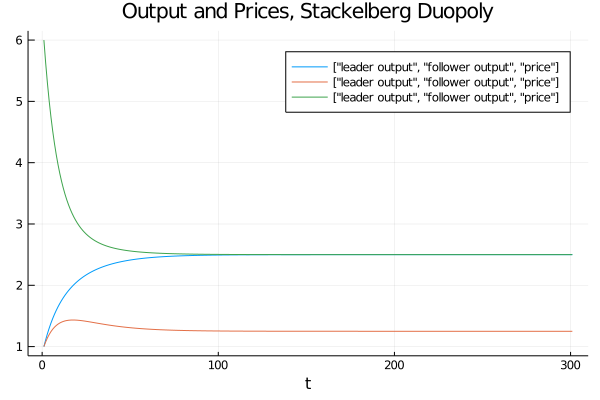

In [5]:
q_leader = yt[2, 1:end];
q_follower = yt[3, 1:end];
q = q_leader + q_follower;
p = a0 .- a1*q;

plot(1:n+1, [q_leader, q_follower, p],
    title = "Output and Prices, Stackelberg Duopoly",
    labels = ["leader output", "follower output", "price"],
    xlabel = "t")

### Value of Stackelberg Leader

We’ll compute the present value earned by the Stackelberg leader.

We’ll compute it two ways (they give identical answers – just a check
on coding and thinking)

In [6]:
v_leader_forward = sum(βs .* π_leader);
v_leader_direct = -yt[:, 1]' * P * yt[:, 1];

println("v_leader_forward (forward sim) is $v_leader_forward")
println("v_leader_direct is $v_leader_direct")

v_leader_forward (forward sim) is 150.0316212532548
v_leader_direct is 150.03237147548847


In [7]:
# manually check whether P is an approximate fixed point
P_next = (R + F' * Q * F + β * (A - B * F)' * P * (A - B * F));
all(P - P_next .< tol0)

true

In [8]:
# manually checks whether two different ways of computing the
# value function give approximately the same answer
v_expanded = -((y0' * R * y0 + ut[:, 1]' * Q * ut[:, 1] +
           β * (y0' * (A - B * F)' * P * (A - B * F) * y0)));
(v_leader_direct - v_expanded < tol0)[1, 1]

true

## Exhibiting Time Inconsistency of Stackelberg Plan

In the code below we compare two values

- the continuation value $ - y_t P y_t $ earned by a continuation
  Stackelberg leader who inherits state $ y_t $ at $ t $  
- the value of a **reborn Stackelberg leader** who inherits state
  $ z_t $ at $ t $ and sets $ x_t = - P_{22}^{-1} P_{21} $  


The difference between these two values is a tell-tale time of the time
inconsistency of the Stackelberg plan

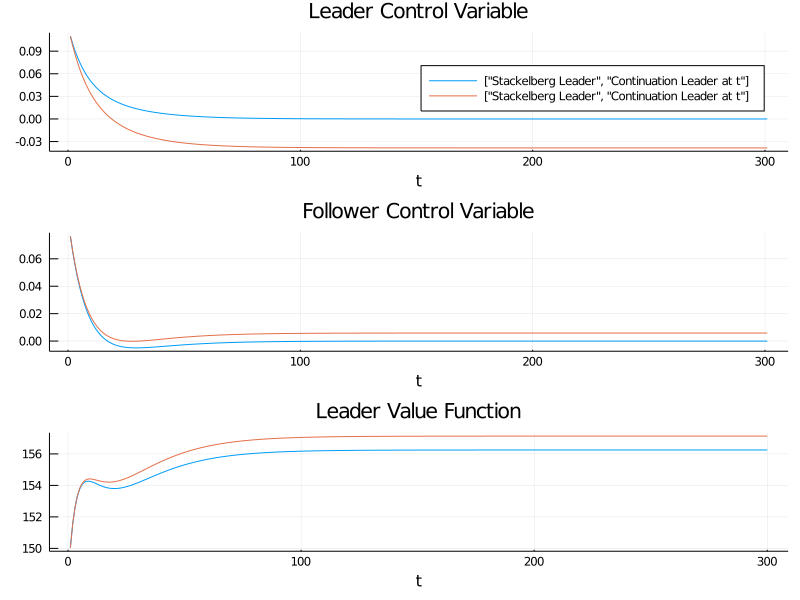

In [9]:
# Compute value function over time with reset at time t
vt_leader = zeros(n);
vt_reset_leader = similar(vt_leader);

yt_reset = copy(yt)
yt_reset[end, :] = (H_0_0 * yt[1:3, :])

for t in 1:n
    vt_leader[t] = -yt[:, t]' * P * yt[:, t]
    vt_reset_leader[t] = -yt_reset[:, t]' * P * yt_reset[:, t]
end

p1 = plot(1:n+1, [(-F * yt)', (-F * yt_reset)'], labels = ["Stackelberg Leader", "Continuation Leader at t"],
        title = "Leader Control Variable", xlabel = "t");
p2 = plot(1:n+1, [yt[4, :], yt_reset[4, :]], title = "Follower Control Variable", xlabel = "t", legend = false);
p3 = plot(1:n, [vt_leader, vt_reset_leader], legend = false,
            xlabel = "t", title = "Leader Value Function");
plot(p1, p2, p3, layout = (3, 1), size = (800, 600))

## Recursive Formulation of the Follower’s Problem

We now formulate and compute the recursive version of the follower’s
problem.

We check that the recursive **Big** $ K $ **, little** $ k $ formulation of the follower’s problem produces the same output path
$ \vec q_1 $ that we computed when we solved the Stackelberg problem

In [10]:
Ã = I + zeros(5, 5);
Ã[1:4, 1:4] .= A - B * F;
R̃ = [0 0 0 0 -a0/2; 0 0 0 0 a1/2; 0 0 0 0 0; 0 0 0 0 0; -a0/2 a1/2 0 0 a1];
Q̃ = Q;
B̃ = [0, 0, 0, 0, 1];

lq_tilde = QuantEcon.LQ(Q̃, R̃, Ã, B̃, bet=β);
P̃, F̃, d̃ = stationary_values(lq_tilde);
y0_tilde = vcat(y0, y0[3]);
yt_tilde = compute_sequence(lq_tilde, y0_tilde, n)[1];

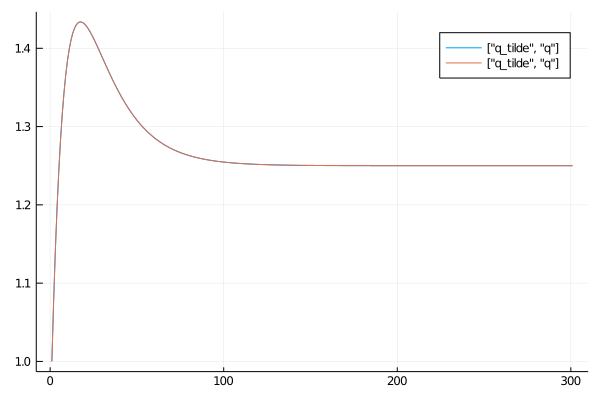

In [11]:
# checks that the recursive formulation of the follower's problem gives
# the same solution as the original Stackelberg problem
plot(1:n+1, [yt_tilde[5, :], yt_tilde[3, :]], labels = ["q_tilde", "q"])

Note: Variables with `_tilde` are obtained from solving the follower’s
problem – those without are from the Stackelberg problem.

In [12]:
# maximum absolute difference in quantities over time between the first and second solution methods
max(abs(yt_tilde[5] - yt_tilde[3]))

0.0

In [13]:
# x0 == x0_tilde
yt[:, 1][end] - (yt_tilde[:, 2] - yt_tilde[:, 1])[end] < tol0

true

### Explanation of Alignment

If we inspect the coefficients in the decision rule $ - \tilde F $,
we can spot the reason that the follower chooses to set $ x_t =
\tilde x_t $ when it sets $ x_t = - \tilde F X_t $ in
the recursive formulation of the follower problem.

Can you spot what features of $ \tilde F $ imply this?

Hint: remember the components of $ X_t $

In [14]:
F̃ # policy function in the follower's problem

1×5 Array{Float64,2}:
 2.5489e-17  -3.18612e-18  -0.103187  -1.0  0.103187

In [15]:
P # value function in the Stackelberg problem

4×4 Array{Float64,2}:
   963.541  -194.605   -511.622   -5258.23
  -194.605    37.3536    81.9771    784.765
  -511.622    81.9771   247.343    2517.05
 -5258.23    784.765   2517.05    25556.2

In [16]:
P̃ # value function in the follower's problem

5×5 Array{Float64,2}:
 -18.1991     2.58003     15.6049     151.23      -5.0
   2.58003   -0.969466    -5.26008    -50.9764     1.0
  15.6049    -5.26008    -32.2759    -312.792    -12.3824
 151.23     -50.9764    -312.792    -3031.33    -120.0
  -5.0        1.0        -12.3824    -120.0       14.3824

In [17]:
# manually check that P is an approximate fixed point
all((P  - ((R + F' * Q * F) + β * (A - B * F)' * P * (A - B * F)) .< tol0))

true

In [18]:
# compute `P_guess` using `F_tilde_star`
F̃_star = -[0, 0, 0, 1, 0]';
P_guess = zeros(5, 5);

for i in 1:1000
    P_guess = ((R̃ + F̃_star' * Q̃ * F̃_star) +
               β * (Ã - B̃ * F̃_star)' * P_guess
               * (Ã - B̃ * F̃_star));
end

In [19]:
# value function in the follower's problem
-(y0_tilde' * P̃ * y0_tilde)[1, 1]

112.65590740578102

In [20]:
# value function using P_guess
-(y0_tilde' * P_guess * y0_tilde)[1, 1]

112.65590740578097

In [21]:
# c policy using policy iteration algorithm
F_iter = (β * inv(Q + β * B̃' * P_guess * B̃)
      * B̃' * P_guess * Ã);
P_iter = zeros(5, 5);
dist_vec = zeros(5, 5);

for i in 1:100
    # compute P_iter
    dist_vec = similar(P_iter)
    for j in 1:1000
        P_iter = (R̃ + F_iter' * Q * F_iter) + β *
                  (Ã - B̃ * F_iter)' * P_iter *
                  (Ã - B̃ * F_iter);

        # update F_iter
        F_iter = β * inv(Q + β * B̃' * P_iter * B̃) *
                    B̃' * P_iter * Ã;

        dist_vec = P_iter - ((R̃ + F_iter' * Q * F_iter) +
                β * (Ã - B̃ * F_iter)' * P_iter *
                (Ã - B̃ * F_iter));
    end
end

if maximum(abs.(dist_vec)) < 1e-8
    dist_vec2 = F_iter - (β * inv(Q + β * B̃' * P_iter * B̃) * B̃' * P_iter * Ã)
        if maximum(abs.(dist_vec2)) < 1e-8
            @show F_iter
        else
            println("The policy didn't converge: try increasing the number of outer loop iterations")
        end
else
    println("The policy didn't converge: try increasing the number of inner loop iterations")
end

F_iter = [0.0 -1.474514954580286e-17 -0.1031865014522383 -1.0000000000000007 0.10318650145223823]


1×5 Adjoint{Float64,Array{Float64,1}}:
 0.0  -1.47451e-17  -0.103187  -1.0  0.103187

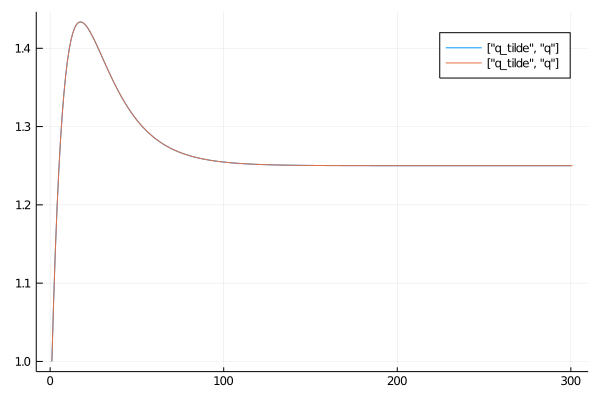

In [22]:
yt_tilde_star = zeros(n, 5);
yt_tilde_star[1, :] = y0_tilde;

for t in 1:n-1
    yt_tilde_star[t+1, :] = (Ã - B̃ * F̃_star) * yt_tilde_star[t, :];
end

plot([yt_tilde_star[:, 5], yt_tilde[3, :]], labels = ["q_tilde", "q"])

In [23]:
maximum(abs.(yt_tilde_star[:, 5] - yt_tilde[3, 1:end-1]))

0.0

## Markov Perfect Equilibrium

The **state** vector is

$$
z_t = \begin{bmatrix} 1 \cr q_{2t} \cr q_{1t} \end{bmatrix}
$$

and the state transition dynamics are

$$
z_{t+1} = A z_t + B_1 v_{1t}  +  B_2 v_{2t}
$$

where $ A $ is a $ 3 \times 3 $ identity matrix and

$$
B_1 = \begin{bmatrix} 0 \cr 0 \cr 1 \end{bmatrix} ,
\quad B_2 = \begin{bmatrix} 0 \cr 1 \cr 0 \end{bmatrix}
$$

The Markov perfect decision rules are

$$
v_{1t} = - F_1 z_t , \quad v_{2t} = - F_2 z_t
$$

and in the Markov perfect equilibrium the state evolves according to

$$
z_{t+1} = (A - B_1 F_1 - B_2 F_2) z_t
$$

In [24]:
# in LQ form
A = I + zeros(3, 3);
B1 = [0, 0, 1];
B2 = [0, 1, 0];
R1 = [0 0 -a0/2; 0 0 a1/2; -a0/2 a1/2 a1];
R2 = [0 -a0/2 0; -a0/2 a1 a1/2; 0 a1/2 0];
Q1 = Q2 = γ;
S1 = S2 = W1 = W2 = M1 = M2 = 0.;

# solve using nnash from QE
F1, F2, P1, P2 = nnash(A, B1, B2, R1, R2, Q1, Q2,
                        S1, S2, W1, W2, M1, M2,
                        beta = β,
                        tol = tol1);

# simulate forward
AF = A - B1 * F1 - B2 * F2;
z = zeros(3, n);
z[:, 1] .= 1;
for t in 1:n-1
    z[:, t+1] = AF * z[:, t]
end

println("Policy for F1 is $F1")
println("Policy for F2 is $F2")

Policy for F1 is [-0.22701362843207126 0.03129874118441059 0.09447112842804818]
Policy for F2 is [-0.22701362843207126 0.09447112842804818 0.03129874118441059]


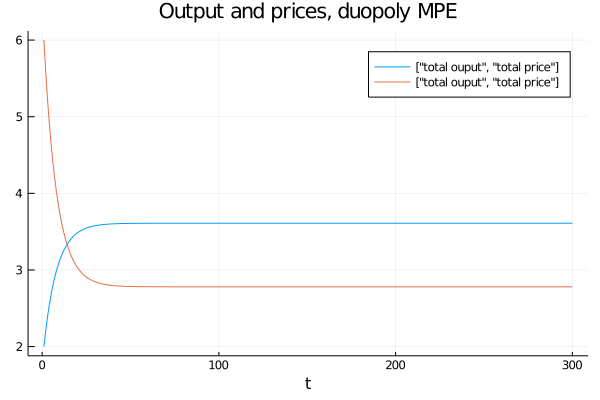

In [25]:
q1 = z[2, :];
q2 = z[3, :];
q = q1 + q2; # total output, MPE
p = a0 .- a1 * q; # total price, MPE
plot([q, p], labels = ["total ouput", "total price"], title = "Output and prices, duopoly MPE", xlabel = "t")

In [26]:
# computes the maximum difference in quantities across firms
maximum(abs.(q1 - q2))

8.881784197001252e-16

In [27]:
# compute values
u1 = -F1 * z;
u2 = -F2 * z;
π_1 = (p .* q1)' - γ * u1.^2;
π_2 = (p .* q2)' - γ * u2.^2;

v1_forward = π_1 * βs;
v2_forward = π_2 * βs;

v1_direct = -z[:, 1]' * P1 * z[:, 1];
v2_direct = -z[:, 1]' * P2 * z[:, 1];

println("Firm 1: Direct is $v1_direct, Forward is $(v1_forward[1])");
println("Firm 2: Direct is $v2_direct, Forward is $(v2_forward[1])");

Firm 1: Direct is 133.3295555721595, Forward is 133.33033197956638
Firm 2: Direct is 133.32955557215945, Forward is 133.33033197956638


In [28]:
# sanity check
Λ_1 = A - B2 * F2;
lq1 = QuantEcon.LQ(Q1, R1, Λ_1, B1, bet = β);
P1_ih, F1_ih, d = stationary_values(lq1);

v2_direct_alt = -z[:, 1]' * P1_ih * z[:, 1] + d;
all(abs.(v2_direct - v2_direct_alt) < tol2)

true

## MPE vs. Stackelberg

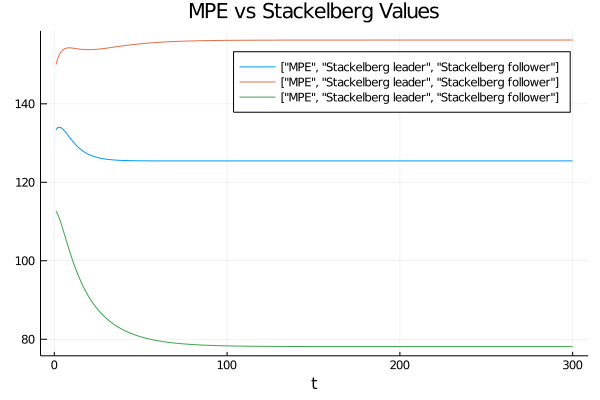

In [29]:
vt_MPE = zeros(n);
vt_follower = zeros(n);

for t in 1:n
    vt_MPE[t] = -z[:, t]' * P1 * z[:, t];
    vt_follower[t] = -yt_tilde[:, t]' * P̃ * yt_tilde[:, t];
end

plot([vt_MPE, vt_leader, vt_follower], labels = ["MPE", "Stackelberg leader",
        "Stackelberg follower"], title = "MPE vs Stackelberg Values",
        xlabel = "t")

In [30]:
# display values
println("vt_leader(y0) = $(vt_leader[1])");
println("vt_follower(y0) = $(vt_follower[1])")
println("vt_MPE(y0) = $(vt_MPE[1])");

vt_leader(y0) = 150.03237147548847
vt_follower(y0) = 112.65590740578102
vt_MPE(y0) = 133.3295555721595


In [31]:
# total difference in value b/t Stackelberg and MPE
vt_leader[1] + vt_follower[1] - 2*vt_MPE[1]

-3.9708322630494877